<a href="https://colab.research.google.com/github/daehan2yang/Leanring/blob/main/MNIST_%ED%95%99%EC%8A%B5_%EA%B3%BC%EC%A0%9C_%EC%96%91%EB%8C%80%ED%95%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 모듈 설치 및 불러오기
!pip install torchvision --quiet

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
# 하이퍼파라미터 설정
TARGET_DIGIT = 3
HIDDEN_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 10
BATCH_SIZE = 64


In [ ]:
# MNIST 데이터 불러오기 및 0~1 정규화
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 데이터 -> numpy 배열 변환
x_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_train = (train_dataset.targets.numpy() == TARGET_DIGIT).astype(np.int32)

x_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_test = (test_dataset.targets.numpy() == TARGET_DIGIT).astype(np.int32)


In [ ]:
class NumpyMLP:
    def __init__(self, input_size, hidden_size):
        self.w1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, 1) * 0.01
        self.b2 = np.zeros((1, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def forward(self, x):
        self.z1 = x @ self.w1 + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = self.a1 @ self.w2 + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, x, y, output):
        m = x.shape[0]
        dz2 = output - y.reshape(-1, 1)
        dw2 = self.a1.T @ dz2 / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = (dz2 @ self.w2.T) * self.sigmoid_deriv(self.z1)
        dw1 = x.T @ dz1 / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.w1 -= LEARNING_RATE * dw1
        self.b1 -= LEARNING_RATE * db1
        self.w2 -= LEARNING_RATE * dw2
        self.b2 -= LEARNING_RATE * db2

    def train(self, x, y):
        for epoch in range(EPOCHS):
            out = self.forward(x)
            loss = np.mean((out - y.reshape(-1, 1))**2)
            self.backward(x, y, out)
            if epoch % 1 == 0:
                print(f"[NumPy] Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f}")

    def predict(self, x):
        out = self.forward(x)
        return (out > 0.5).astype(np.int32).flatten()


In [ ]:
# 학습 및 평가
np_mlp = NumpyMLP(784, HIDDEN_SIZE)
np_mlp.train(x_train, y_train)
np_preds = np_mlp.predict(x_test)

print(classification_report(y_test, np_preds, target_names=["Not Target", "Target"]))

[NumPy] Epoch 1/10 - Loss: 0.2464
[NumPy] Epoch 2/10 - Loss: 0.2395
[NumPy] Epoch 3/10 - Loss: 0.2329
[NumPy] Epoch 4/10 - Loss: 0.2266
[NumPy] Epoch 5/10 - Loss: 0.2206
[NumPy] Epoch 6/10 - Loss: 0.2148
[NumPy] Epoch 7/10 - Loss: 0.2094
[NumPy] Epoch 8/10 - Loss: 0.2042
[NumPy] Epoch 9/10 - Loss: 0.1992
[NumPy] Epoch 10/10 - Loss: 0.1945
              precision    recall  f1-score   support

  Not Target       0.90      1.00      0.95      8990
      Target       0.00      0.00      0.00      1010

    accuracy                           0.90     10000
   macro avg       0.45      0.50      0.47     10000
weighted avg       0.81      0.90      0.85     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
class TorchMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # 입력 -> 은닉층 -> 출력층 구조 정의
        self.fc1 = nn.Linear(input_size, hidden_size)  # 첫 번째 완전연결층
        self.relu = nn.ReLU()                          # ReLU 활성화 함수
        self.fc2 = nn.Linear(hidden_size, 1)           # 출력층 (이진 분류용)
        self.sigmoid = nn.Sigmoid()                    # 확률 출력용 시그모이드

    def forward(self, x):
        # 순전파 과정 정의
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)  # 최종 확률 출력 (0~1 사이)


In [ ]:
# 데이터 텐서 변환
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 모델 초기화
torch_model = TorchMLP(784, HIDDEN_SIZE)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)

# 학습 반복
for epoch in range(EPOCHS):
    optimizer.zero_grad()                         # 그래디언트 초기화
    outputs = torch_model(x_train_tensor)         # 순전파
    loss = criterion(outputs, y_train_tensor)     # 손실 계산
    loss.backward()                               # 역전파
    optimizer.step()                              # 파라미터 업데이트

    print(f"[PyTorch] Epoch {epoch+1}/{EPOCHS} - Loss: {loss.item():.4f}")


# 예측 및 평가
with torch.no_grad():
    test_outputs = torch_model(x_test_tensor)
    predictions = (test_outputs > 0.5).int().numpy().flatten()  # 확률 -> 클래스 변환

# sklearn을 이용한 평가 지표 출력
print(classification_report(y_test, predictions, target_names=["Not Target", "Target"]))

[PyTorch] Epoch 1/10 - Loss: 0.5669
[PyTorch] Epoch 2/10 - Loss: 0.3890
[PyTorch] Epoch 3/10 - Loss: 0.3923
[PyTorch] Epoch 4/10 - Loss: 0.3366
[PyTorch] Epoch 5/10 - Loss: 0.2777
[PyTorch] Epoch 6/10 - Loss: 0.2414
[PyTorch] Epoch 7/10 - Loss: 0.2309
[PyTorch] Epoch 8/10 - Loss: 0.2300
[PyTorch] Epoch 9/10 - Loss: 0.2221
[PyTorch] Epoch 10/10 - Loss: 0.2062
              precision    recall  f1-score   support

  Not Target       0.90      1.00      0.95      8990
      Target       0.00      0.00      0.00      1010

    accuracy                           0.90     10000
   macro avg       0.45      0.50      0.47     10000
weighted avg       0.81      0.90      0.85     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NumPy] Epoch 1/10 - Loss: 0.2425
[NumPy] Epoch 2/10 - Loss: 0.2359
[NumPy] Epoch 3/10 - Loss: 0.2295
[NumPy] Epoch 4/10 - Loss: 0.2234
[NumPy] Epoch 5/10 - Loss: 0.2177
[NumPy] Epoch 6/10 - Loss: 0.2121
[NumPy] Epoch 7/10 - Loss: 0.2069
[NumPy] Epoch 8/10 - Loss: 0.2018
[NumPy] Epoch 9/10 - Loss: 0.1970
[NumPy] Epoch 10/10 - Loss: 0.1925
[NumPy] Elapsed Time: 9.1124 seconds
[PyTorch] Elapsed Time: 2.0742 seconds
[NumPy] Accuracy: 0.8990
[PyTorch] Accuracy: 0.8990

NumPy Classification Report:
              precision    recall  f1-score   support

  Not Target       0.90      1.00      0.95      8990
      Target       0.00      0.00      0.00      1010

    accuracy                           0.90     10000
   macro avg       0.45      0.50      0.47     10000
weighted avg       0.81      0.90      0.85     10000


PyTorch Classification Report:
              precision    recall  f1-score   support

  Not Target       0.90      1.00      0.95      8990
      Target       0.00      0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

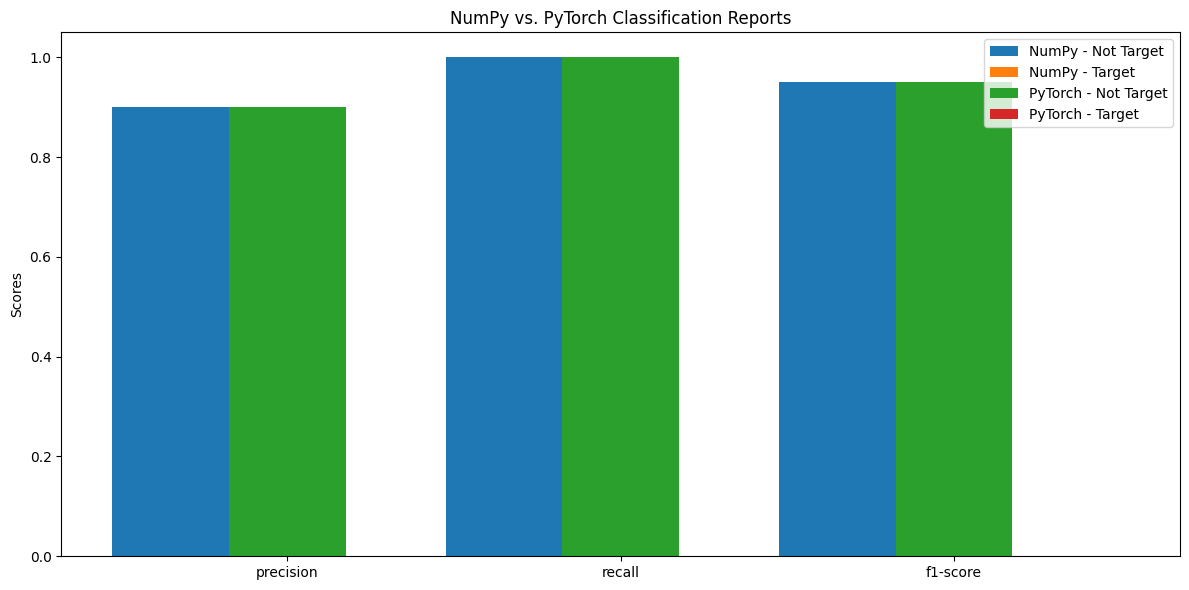

In [ ]:
import time

# NumPy MLP 성능 측정
start_time = time.time()
np_mlp = NumpyMLP(784, HIDDEN_SIZE)
np_mlp.train(x_train, y_train)
np_preds = np_mlp.predict(x_test)
np_elapsed_time = time.time() - start_time

# PyTorch MLP 성능 측정
start_time = time.time()
torch_model = TorchMLP(784, HIDDEN_SIZE)
criterion = nn.BCELoss()
optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = torch_model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    test_outputs = torch_model(x_test_tensor)
    torch_preds = (test_outputs > 0.5).int().numpy().flatten()

torch_elapsed_time = time.time() - start_time

# 결과 출력
print(f"[NumPy] Elapsed Time: {np_elapsed_time:.4f} seconds")
print(f"[PyTorch] Elapsed Time: {torch_elapsed_time:.4f} seconds")

# 성능 비교 (예: 정확도)
np_accuracy = accuracy_score(y_test, np_preds)
torch_accuracy = accuracy_score(y_test, torch_preds)

print(f"[NumPy] Accuracy: {np_accuracy:.4f}")
print(f"[PyTorch] Accuracy: {torch_accuracy:.4f}")

# 추가적인 성능 지표 (precision, recall, F1-score) 출력
print("\nNumPy Classification Report:")
print(classification_report(y_test, np_preds, target_names=["Not Target", "Target"]))

print("\nPyTorch Classification Report:")
print(classification_report(y_test, torch_preds, target_names=["Not Target", "Target"]))

# 막대 그래프 그리기 함수
def plot_classification_reports(reports, titles):
    metrics = ['precision', 'recall', 'f1-score']
    classes = ['Not Target', 'Target']

    fig, ax = plt.subplots(figsize=(12, 6))  # 더 넓은 그래프 크기

    x = np.arange(len(metrics))
    width = 0.35  # 막대 너비

    # reports와 titles를 반복하여 각 분류 보고서를 그래프에 추가
    for i, (report, title) in enumerate(zip(reports, titles)):
        report_type = title.split()[0]  # NumPy 또는 PyTorch 추출
        for j, cls in enumerate(classes):
            ax.bar(x + (j - 0.5) * width + i * width,
                   [report[metric][j] for metric in metrics],
                   width, label=f'{report_type} - {cls}')

    ax.set_ylabel('Scores')
    ax.set_title('NumPy vs. PyTorch Classification Reports')  # 제목 변경
    ax.set_xticks(x + width / 2)  # x축 눈금 위치 조정
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.tight_layout()
    plt.show()

# NumPy와 PyTorch 분류 보고서를 함께 그래프에 표시
plot_classification_reports([numpy_report, pytorch_report],
                            ['NumPy Classification Report', 'PyTorch Classification Report'])

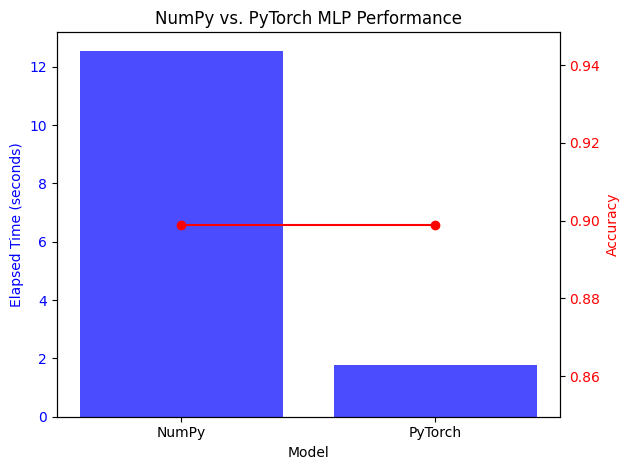

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# 결과 그래프로 시각화
labels = ['NumPy', 'PyTorch']
elapsed_times = [np_elapsed_time, torch_elapsed_time]
accuracies = [np_accuracy, torch_accuracy]

fig, ax1 = plt.subplots()

# 실행 시간 그래프
ax1.set_xlabel('Model')
ax1.set_ylabel('Elapsed Time (seconds)', color='blue')
ax1.bar(labels, elapsed_times, color='blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='blue')

# 정확도 그래프
ax2 = ax1.twinx()  # 두 번째 y축 생성
ax2.set_ylabel('Accuracy', color='red')
ax2.plot(labels, accuracies, color='red', marker='o')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('NumPy vs. PyTorch MLP Performance')
plt.tight_layout()
plt.show()

[NumPy] Epoch 1/10 - Loss: 0.2468
[NumPy] Epoch 2/10 - Loss: 0.2429
[NumPy] Epoch 3/10 - Loss: 0.2391
[NumPy] Epoch 4/10 - Loss: 0.2354
[NumPy] Epoch 5/10 - Loss: 0.2318
[NumPy] Epoch 6/10 - Loss: 0.2283
[NumPy] Epoch 7/10 - Loss: 0.2249
[NumPy] Epoch 8/10 - Loss: 0.2215
[NumPy] Epoch 9/10 - Loss: 0.2183
[NumPy] Epoch 10/10 - Loss: 0.2151
[NumPy] Epoch 1/10 - Loss: 0.2529
[NumPy] Epoch 2/10 - Loss: 0.2457
[NumPy] Epoch 3/10 - Loss: 0.2388
[NumPy] Epoch 4/10 - Loss: 0.2323
[NumPy] Epoch 5/10 - Loss: 0.2260
[NumPy] Epoch 6/10 - Loss: 0.2200
[NumPy] Epoch 7/10 - Loss: 0.2143
[NumPy] Epoch 8/10 - Loss: 0.2089
[NumPy] Epoch 9/10 - Loss: 0.2037
[NumPy] Epoch 10/10 - Loss: 0.1988
[NumPy] Epoch 1/10 - Loss: 0.2624
[NumPy] Epoch 2/10 - Loss: 0.2481
[NumPy] Epoch 3/10 - Loss: 0.2349
[NumPy] Epoch 4/10 - Loss: 0.2230
[NumPy] Epoch 5/10 - Loss: 0.2120
[NumPy] Epoch 6/10 - Loss: 0.2020
[NumPy] Epoch 7/10 - Loss: 0.1930
[NumPy] Epoch 8/10 - Loss: 0.1847
[NumPy] Epoch 9/10 - Loss: 0.1772
[NumPy] Epoc

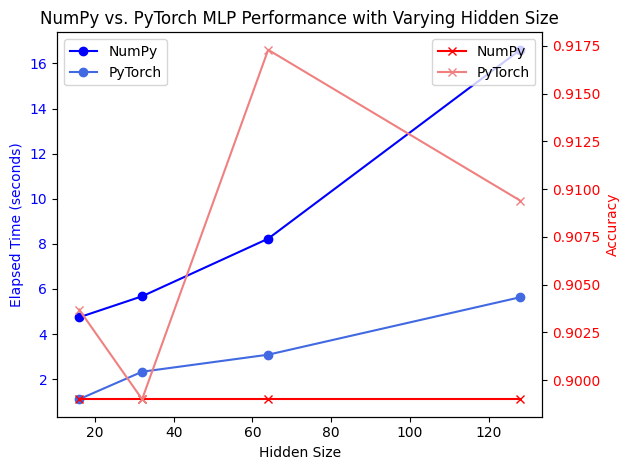

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

# HIDDEN_SIZE 값 리스트

TARGET_DIGIT = 3       # 분류하고자 하는 숫자 (0~9 중 하나 선택)
hidden_sizes = [16, 32, 64, 128]
LEARNING_RATE = 0.01
EPOCHS = 10
BATCH_SIZE = 64
# 결과 저장용 리스트
np_elapsed_times = []
torch_elapsed_times = []
np_accuracies = []
torch_accuracies = []

# 각 HIDDEN_SIZE 값에 대해 실험
for hidden_size in hidden_sizes:
    # NumPy MLP
    start_time = time.time()
    np_mlp = NumpyMLP(784, hidden_size)
    np_mlp.train(x_train, y_train)
    np_preds = np_mlp.predict(x_test)
    np_elapsed_time = time.time() - start_time
    np_accuracy = accuracy_score(y_test, np_preds)

    # PyTorch MLP
    start_time = time.time()
    torch_model = TorchMLP(784, hidden_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        outputs = torch_model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        test_outputs = torch_model(x_test_tensor)
        torch_preds = (test_outputs > 0.5).int().numpy().flatten()
    torch_elapsed_time = time.time() - start_time
    torch_accuracy = accuracy_score(y_test, torch_preds)

    # 결과 저장
    np_elapsed_times.append(np_elapsed_time)
    torch_elapsed_times.append(torch_elapsed_time)
    np_accuracies.append(np_accuracy)
    torch_accuracies.append(torch_accuracy)



# 그래프 그리기
fig, ax1 = plt.subplots()

# 실행 시간 그래프
ax1.set_xlabel('Hidden Size')
ax1.set_ylabel('Elapsed Time (seconds)', color='blue')
ax1.plot(hidden_sizes, np_elapsed_times, color='blue', marker='o', label='NumPy')
ax1.plot(hidden_sizes, torch_elapsed_times, color='royalblue', marker='o', label='PyTorch')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 정확도 그래프
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='red')
ax2.plot(hidden_sizes, np_accuracies, color='red', marker='x', label='NumPy')
ax2.plot(hidden_sizes, torch_accuracies, color='lightcoral', marker='x', label='PyTorch')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('NumPy vs. PyTorch MLP Performance with Varying Hidden Size')
plt.tight_layout()
plt.show()

[NumPy] Epoch 1/10 - Loss: 0.2426
[NumPy] Epoch 2/10 - Loss: 0.2359
[NumPy] Epoch 3/10 - Loss: 0.2295
[NumPy] Epoch 4/10 - Loss: 0.2233
[NumPy] Epoch 5/10 - Loss: 0.2175
[NumPy] Epoch 6/10 - Loss: 0.2119
[NumPy] Epoch 7/10 - Loss: 0.2066
[NumPy] Epoch 8/10 - Loss: 0.2015
[NumPy] Epoch 9/10 - Loss: 0.1967
[NumPy] Epoch 10/10 - Loss: 0.1921
[NumPy] Epoch 1/10 - Loss: 0.2455
[NumPy] Epoch 2/10 - Loss: 0.2386
[NumPy] Epoch 3/10 - Loss: 0.2320
[NumPy] Epoch 4/10 - Loss: 0.2258
[NumPy] Epoch 5/10 - Loss: 0.2198
[NumPy] Epoch 6/10 - Loss: 0.2141
[NumPy] Epoch 7/10 - Loss: 0.2087
[NumPy] Epoch 8/10 - Loss: 0.2035
[NumPy] Epoch 9/10 - Loss: 0.1986
[NumPy] Epoch 10/10 - Loss: 0.1939
[NumPy] Epoch 1/10 - Loss: 0.2569
[NumPy] Epoch 2/10 - Loss: 0.2495
[NumPy] Epoch 3/10 - Loss: 0.2424
[NumPy] Epoch 4/10 - Loss: 0.2356
[NumPy] Epoch 5/10 - Loss: 0.2291
[NumPy] Epoch 6/10 - Loss: 0.2229
[NumPy] Epoch 7/10 - Loss: 0.2170
[NumPy] Epoch 8/10 - Loss: 0.2114
[NumPy] Epoch 9/10 - Loss: 0.2061
[NumPy] Epoc

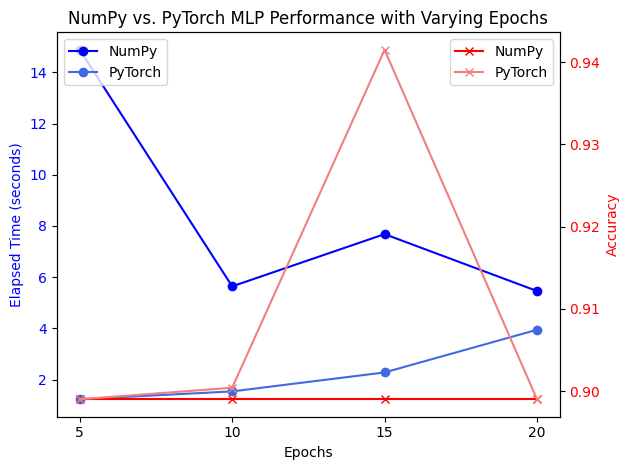

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

# EPOCHS 값 리스트
epochs_list = [5, 10, 15, 20]
TARGET_DIGIT = 3       # 분류하고자 하는 숫자 (0~9 중 하나 선택)
HIDDEN_SIZE = 32
LEARNING_RATE = 0.01
BATCH_SIZE = 64
# 결과 저장용 리스트
np_elapsed_times = []
torch_elapsed_times = []
np_accuracies = []
torch_accuracies = []

# 각 EPOCHS 값에 대해 실험
for epochs in epochs_list:
    # NumPy MLP
    start_time = time.time()
    np_mlp = NumpyMLP(784, HIDDEN_SIZE)  # HIDDEN_SIZE는 기존 값 사용
    np_mlp.train(x_train, y_train)  # epochs는 train 함수 내부에서 사용
    np_preds = np_mlp.predict(x_test)
    np_elapsed_time = time.time() - start_time
    np_accuracy = accuracy_score(y_test, np_preds)

    # PyTorch MLP
    start_time = time.time()
    torch_model = TorchMLP(784, HIDDEN_SIZE)  # HIDDEN_SIZE는 기존 값 사용
    criterion = nn.BCELoss()
    optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)
    for epoch in range(epochs):  # epochs 값 사용
        optimizer.zero_grad()
        outputs = torch_model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        test_outputs = torch_model(x_test_tensor)
        torch_preds = (test_outputs > 0.5).int().numpy().flatten()
    torch_elapsed_time = time.time() - start_time
    torch_accuracy = accuracy_score(y_test, torch_preds)

    # 결과 저장
    np_elapsed_times.append(np_elapsed_time)
    torch_elapsed_times.append(torch_elapsed_time)
    np_accuracies.append(np_accuracy)
    torch_accuracies.append(torch_accuracy)

# 그래프 그리기
fig, ax1 = plt.subplots()

# 실행 시간 그래프
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Elapsed Time (seconds)', color='blue')
ax1.plot(epochs_list, np_elapsed_times, color='blue', marker='o', label='NumPy')
ax1.plot(epochs_list, torch_elapsed_times, color='royalblue', marker='o', label='PyTorch')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 정확도 그래프
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='red')
ax2.plot(epochs_list, np_accuracies, color='red', marker='x', label='NumPy')
ax2.plot(epochs_list, torch_accuracies, color='lightcoral', marker='x', label='PyTorch')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')


plt.title('NumPy vs. PyTorch MLP Performance with Varying Epochs')
plt.xticks(epochs_list)  # x축 눈금을 epochs_list 값으로 설정
plt.tight_layout()
plt.show()

[NumPy] Epoch 1/10 - Loss: 0.2542
[NumPy] Epoch 2/10 - Loss: 0.2534
[NumPy] Epoch 3/10 - Loss: 0.2527
[NumPy] Epoch 4/10 - Loss: 0.2520
[NumPy] Epoch 5/10 - Loss: 0.2513
[NumPy] Epoch 6/10 - Loss: 0.2505
[NumPy] Epoch 7/10 - Loss: 0.2498
[NumPy] Epoch 8/10 - Loss: 0.2491
[NumPy] Epoch 9/10 - Loss: 0.2484
[NumPy] Epoch 10/10 - Loss: 0.2477
[NumPy] Epoch 1/10 - Loss: 0.2458
[NumPy] Epoch 2/10 - Loss: 0.2389
[NumPy] Epoch 3/10 - Loss: 0.2324
[NumPy] Epoch 4/10 - Loss: 0.2261
[NumPy] Epoch 5/10 - Loss: 0.2201
[NumPy] Epoch 6/10 - Loss: 0.2145
[NumPy] Epoch 7/10 - Loss: 0.2090
[NumPy] Epoch 8/10 - Loss: 0.2039
[NumPy] Epoch 9/10 - Loss: 0.1989
[NumPy] Epoch 10/10 - Loss: 0.1943
[NumPy] Epoch 1/10 - Loss: 0.2516
[NumPy] Epoch 2/10 - Loss: 0.1887
[NumPy] Epoch 3/10 - Loss: 0.1520
[NumPy] Epoch 4/10 - Loss: 0.1305
[NumPy] Epoch 5/10 - Loss: 0.1174
[NumPy] Epoch 6/10 - Loss: 0.1092
[NumPy] Epoch 7/10 - Loss: 0.1039
[NumPy] Epoch 8/10 - Loss: 0.1004
[NumPy] Epoch 9/10 - Loss: 0.0980
[NumPy] Epoc

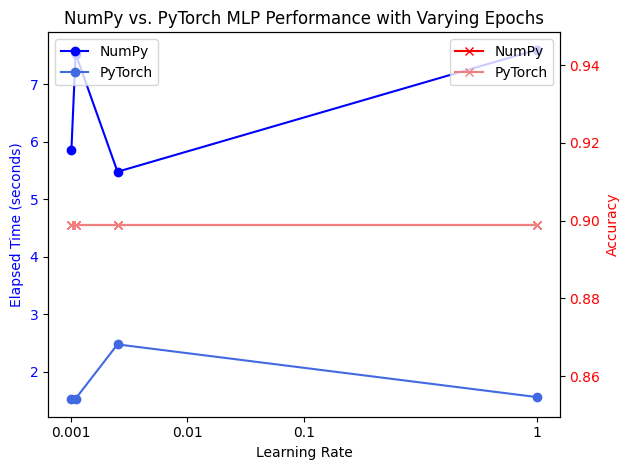

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

# LEARNING_RATE 값 리스트
learning_rates = [0.001, 0.01, 0.1,1]
EPOCHS = 10
TARGET_DIGIT = 3       # 분류하고자 하는 숫자 (0~9 중 하나 선택)
HIDDEN_SIZE = 32
BATCH_SIZE = 64
# 결과 저장용 리스트
np_elapsed_times = []
torch_elapsed_times = []
np_accuracies = []
torch_accuracies = []

# 각 LEARNING_RATE 값에 대해 실험
for lr in learning_rates:
    # NumPy MLP
    #NumPy 에서는 learning rate가 전역변수로 설정되어 있으므로, 여기서 변경합니다.
    global LEARNING_RATE
    LEARNING_RATE = lr

    start_time = time.time()
    np_mlp = NumpyMLP(784, HIDDEN_SIZE)
    np_mlp.train(x_train, y_train)
    np_preds = np_mlp.predict(x_test)
    np_elapsed_time = time.time() - start_time
    np_accuracy = accuracy_score(y_test, np_preds)

    # PyTorch MLP
    start_time = time.time()
    torch_model = TorchMLP(784, HIDDEN_SIZE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(torch_model.parameters(), lr=lr) # learning rate 설정
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        outputs = torch_model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        test_outputs = torch_model(x_test_tensor)
        torch_preds = (test_outputs > 0.5).int().numpy().flatten()
    torch_elapsed_time = time.time() - start_time
    torch_accuracy = accuracy_score(y_test, torch_preds)

    # 결과 저장
    np_elapsed_times.append(np_elapsed_time)
    torch_elapsed_times.append(torch_elapsed_time)
    np_accuracies.append(np_accuracy)
    torch_accuracies.append(torch_accuracy)

# 그래프 그리기
fig, ax1 = plt.subplots()

# 실행 시간 그래프
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Elapsed Time (seconds)', color='blue')
ax1.plot(learning_rates, np_elapsed_times, color='blue', marker='o', label='NumPy')
ax1.plot(learning_rates, torch_elapsed_times, color='royalblue', marker='o', label='PyTorch')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 정확도 그래프
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='red')
ax2.plot(learning_rates, np_accuracies, color='red', marker='x', label='NumPy')
ax2.plot(learning_rates, torch_accuracies, color='lightcoral', marker='x', label='PyTorch')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')


plt.title('NumPy vs. PyTorch MLP Performance with Varying Epochs')
plt.xticks(learning_rates)  # x축 눈금을 epochs_list 값으로 설정
plt.tight_layout()
plt.show()

[NumPy] Epoch 1/10 - Loss: 0.2439
[NumPy] Epoch 2/10 - Loss: 0.2373
[NumPy] Epoch 3/10 - Loss: 0.2309
[NumPy] Epoch 4/10 - Loss: 0.2248
[NumPy] Epoch 5/10 - Loss: 0.2190
[NumPy] Epoch 6/10 - Loss: 0.2135
[NumPy] Epoch 7/10 - Loss: 0.2082
[NumPy] Epoch 8/10 - Loss: 0.2031
[NumPy] Epoch 9/10 - Loss: 0.1983
[NumPy] Epoch 10/10 - Loss: 0.1937


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


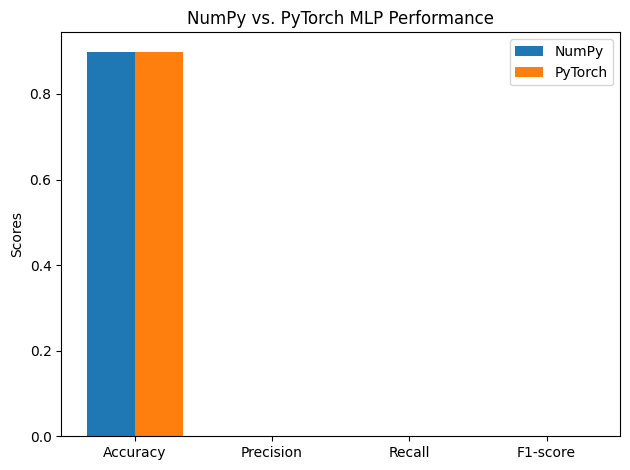

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

# 하이퍼파라미터 설정
TARGET_DIGIT = 3
HIDDEN_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 10
BATCH_SIZE = 64

# 모델 학습 및 예측 (NumPy)
np_mlp = NumpyMLP(784, HIDDEN_SIZE)
np_mlp.train(x_train, y_train)
np_preds = np_mlp.predict(x_test)

# 모델 학습 및 예측 (PyTorch)
torch_model = TorchMLP(784, HIDDEN_SIZE)
criterion = nn.BCELoss()
optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = torch_model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
with torch.no_grad():
    test_outputs = torch_model(x_test_tensor)
    torch_preds = (test_outputs > 0.5).int().numpy().flatten()

# 성능 지표 계산 (NumPy)
np_accuracy = accuracy_score(y_test, np_preds)
np_precision = precision_score(y_test, np_preds)
np_recall = recall_score(y_test, np_preds)
np_f1 = f1_score(y_test, np_preds)

# 성능 지표 계산 (PyTorch)
torch_accuracy = accuracy_score(y_test, torch_preds)
torch_precision = precision_score(y_test, torch_preds)
torch_recall = recall_score(y_test, torch_preds)
torch_f1 = f1_score(y_test, torch_preds)

# 그래프 데이터
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
numpy_scores = [np_accuracy, np_precision, np_recall, np_f1]
pytorch_scores = [torch_accuracy, torch_precision, torch_recall, torch_f1]

# 그래프 그리기
x = np.arange(len(metrics))  # x축 위치
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, numpy_scores, width, label='NumPy')
rects2 = ax.bar(x + width/2, pytorch_scores, width, label='PyTorch')

# 그래프 설정
ax.set_ylabel('Scores')
ax.set_title('NumPy vs. PyTorch MLP Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()